In [24]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,utils
import matplotlib.pyplot as plt
import torch.nn.functional as F

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

trainset=datasets.MNIST('MNIST/',train=True,transform=transform,download=True)
train_loader=DataLoader(trainset,batch_size=64,shuffle=True)

testset=datasets.MNIST('MNIST/',train=False,transform=transform,download=True)
test_loader=DataLoader(testset,batch_size=64,shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


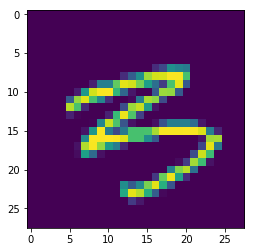

In [25]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [26]:
label

tensor([ 3,  7,  8,  4,  1,  8,  1,  2,  8,  5,  0,  2,  8,  2,
         0,  3,  3,  8,  1,  1,  9,  9,  1,  5,  5,  5,  3,  5,
         4,  8,  5,  1,  5,  4,  1,  6,  5,  9,  8,  8,  8,  1,
         5,  1,  5,  7,  6,  7,  6,  1,  8,  6,  7,  3,  7,  4,
         6,  6,  4,  1,  3,  0,  2,  7])

In [27]:
class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        self.fc1=torch.nn.Linear(784,600)
        self.dropout1=torch.nn.Dropout(p=0.2)
        self.fc2=torch.nn.Linear(600,400)
        self.fc3=torch.nn.Linear(400,200)
        self.dropout2=torch.nn.Dropout(p=0.2)
        self.fc4=torch.nn.Linear(200,100)
        self.fc5=torch.nn.Linear(100,10)
        #self.sigmoid=torch.nn.Sigmoid()
        
        
    def forward(self,x):
        
        x=x.view(-1,784)  #flatten in forward instead of train
        out1=F.relu(self.fc1(x))
        out1=self.dropout1(out1)
        out2=F.relu(self.fc2(out1))
        out2=self.dropout2(out2)
        out3=F.relu(self.fc3(out2))
        out4=F.relu(self.fc4(out3))   #sof max at end, or sigmoid all the way did not work out
        #y_pred=F.softmax(out4,dim=1)   #if don't need probability as out put not necessary output4 is batch_size*10
        y_pred=F.relu(self.fc5(out4))
        return y_pred

model=Network()    
    

In [28]:
epochs=10
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)  #had to change from SGD to Adam but later noy much difference
lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [29]:
#torch.set_printoptions(precision=2)
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for epoch in range(epochs):

        for input,label in iter(train_loader):

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model(input)   #this is 64 (bacth_size)*10

            if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(label==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            if(count%200==0): print('epoch',epoch+1,'/',epochs,'running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))

        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)

train_function(train_loader)

torch.Size([64, 10]) torch.Size([64])
epoch 1 / 10 running_loss: 0.029979440211318435 Accuracy 34.21875
epoch 1 / 10 running_loss: 0.02092610101797618 Accuracy 54.859375
epoch 1 / 10 running_loss: 0.016596486933606987 Accuracy 64.2109375
epoch 1 / 10 running_loss: 0.014219481420295778 Accuracy 69.2109375
epoch 2 / 10 running_loss: 0.01271852817975279 Accuracy 72.26113056528264
epoch 2 / 10 running_loss: 0.011597638621517907 Accuracy 74.51933097123802
epoch 2 / 10 running_loss: 0.01078016967447784 Accuracy 76.16559485530547
epoch 2 / 10 running_loss: 0.01014899551517919 Accuracy 77.42458580806502
epoch 2 / 10 running_loss: 0.009644403651555434 Accuracy 78.42456237843845
epoch 3 / 10 running_loss: 0.009089413476802023 Accuracy 79.66326913456729
epoch 3 / 10 running_loss: 0.008407436779622742 Accuracy 81.22584129149614
epoch 3 / 10 running_loss: 0.007834599041750368 Accuracy 82.53829720716965
epoch 3 / 10 running_loss: 0.007356542650069542 Accuracy 83.65236629472874
epoch 3 / 10 running_l

In [30]:
#torch.set_printoptions(precision=2)
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0



    for input,label in iter(test_loader):
        model.eval()

        #input.resize_(input.size()[0], 784)   take to forward
        y_pred=model(input)   #this is 64 (bacth_size)*10

        #if(count==0): print(y_pred.size(),label.size())
        loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
        loss_running=loss_running+loss.item()
        count=count+1

        count_batch=count_batch+(label.size()[0])
        _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

        acc=(label==y_pred_).sum().item()    #/label.size()[0]
        sum_acc=sum_acc+acc
        if(count%100==0): print('running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




test_function(test_loader)

running_loss: 0.0010182581818116887 Accuracy 98.28125


# 